In [60]:
from openai import OpenAI

# those settings use vLLM server
client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

chat_response = client.chat.completions.create(
    model="Qwen/Qwen3-1.7B",  # use the default server model
    messages=[
        {"role": "developer", "content": "You are a helpful assistant."},
        {"role": "user", "content": "How important is LLMOps on scale 0-10? "},
    ],
    max_completion_tokens=1000,
    # turn off thinking for Qwen with /no_think
    extra_body={"chat_template_kwargs": {"enable_thinking": False}}
)
content = chat_response.choices[0].message.content.strip()
print("Response:\n", content)

Response:
 The importance of **LLMOps** (Large Language Model Operations) on a **scale 0-10** (where 10 is the highest, indicating the most critical) can be evaluated based on its impact, complexity, and the value it brings to the organization. Here's a breakdown:

---

### **Scale 0-10: Importance of LLMOps**

| Scale | Description | Importance (0-10) |
|-------|-------------|------------------|
| **0** | No LLMOps; no models in production. | **0** |
| **1** | Basic LLMOps in development, no production use. | **1** |
| **2** | Minimal LLMOps; models are in development, but not deployed. | **2** |
| **3** | Basic LLMOps: model deployment, monitoring, and basic logging. | **3** |
| **4** | Intermediate LLMOps: model versioning, A/B testing, and basic performance monitoring. | **4** |
| **5** | Advanced LLMOps: model training, fine-tuning, and continuous integration/continuous deployment (CI/CD) pipelines. | **5** |
| **6** | Comprehensive LLMOps: model lifecycle management, governance, 

### Ex. 1.

Quantized model run by:
```bash
uv run vllm serve Qwen/Qwen3-1.7B --port 8000 --max-model-len 8192 --gpu-memory-utilization 0.7
```

##### KV Memory(from startup logs):
**Standard** - Available KV cache memory: *3.58 GiB*

**4-bit** - Available KV cache memory: *5.24 GiB*

##### Inference time for 10 prompts(code from cell below runned 2 times for each model type):
**Standard** - *8.86 s*

**4-bit** - *5.74s*


In [61]:
import time

prompts = [
    "Explain what LLMOps is.",
    "Summarize the transformer architecture.",
    "What is KV cache?",
    "Explain attention complexity.",
    "What is quantization?",
    "Explain bitsandbytes.",
    "What is vLLM?",
    "How does batching improve throughput?",
    "Explain GPU memory fragmentation.",
    "What limits inference throughput?"
]
messages = [{"role": "user", "content": prompt} for prompt in prompts]

start_time = time.time()
chat_response = client.chat.completions.create(
    model="Qwen/Qwen3-1.7B",  # use the default server model
    messages=messages,
    max_completion_tokens=1000,
    # turn off thinking for Qwen with /no_think
    extra_body={"chat_template_kwargs": {"enable_thinking": False}}
)
end_time = time.time()
print(f"Processed {len(prompts)} prompts in {end_time - start_time:.2f} seconds.")
content = chat_response.choices[0].message.content.strip()
print("Response:\n", content)

Processed 10 prompts in 7.30 seconds.
Response:
 Certainly! Here's a detailed explanation of each of the questions you've asked:

---

### **1. What is LLMOps?**

**LLMOps** stands for **Large Language Model Operations**. It is a set of practices and tools used to manage, deploy, and operate large language models (LLMs) in a production environment. LLMOps focuses on:

- **Model deployment**: Deploying LLMs on various platforms (cloud, on-premises, edge devices).
- **Model tuning**: Fine-tuning models for specific tasks or domains.
- **Monitoring and logging**: Tracking model performance, usage, and errors.
- **Scalability and performance optimization**: Ensuring models can handle large-scale inference and training.
- **Security and compliance**: Ensuring models meet regulatory and security requirements.

LLMOps is essential for making large language models practical and efficient for real-world applications.

---

### **2. Summarize the Transformer Architecture**

The **Transformer** a

### Ex. 2

In [62]:
import requests
import io
import polars as pl

def read_remote_csv(url: str, n_rows: int = 20) -> str:
    response = requests.get(url, timeout=10)
    response.raise_for_status()

    df = pl.read_csv(io.BytesIO(response.content))
    head = df.head(n_rows)

    buf = io.StringIO()
    head.write_csv(buf)

    result = {
        "source": url,
        "format": "csv",
        "shape": df.shape,
        "schema": {k: str(v) for k, v in df.schema.items()},
        "preview_rows": n_rows,
        "data": buf.getvalue(),
    }

    return json.dumps(result, indent=2)

def read_remote_parquet(url: str, n_rows: int = 20) -> str:
    response = requests.get(url, timeout=10)
    response.raise_for_status()

    df = pl.read_parquet(io.BytesIO(response.content))

    buf = io.StringIO()
    head = df.head(n_rows)
    head.write_csv(buf)

    result = {
        "source": url,
        "format": "parquet",
        "shape": df.shape,
        "schema": {k: str(v) for k, v in df.schema.items()},
        "preview_rows": n_rows,
        "data": buf.getvalue(),
    }

    return json.dumps(result, indent=2)

In [63]:
import datetime
import json
from typing import Callable

from openai import OpenAI


def make_llm_request(prompt: str) -> str:
    client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

    messages = [
        {"role": "developer", "content": "You are a csv or parquet file assistant."},
        {"role": "user", "content": prompt},
    ]

    tool_definitions, tool_name_to_func = get_tool_definitions()

    # guard: loop limit, we break as soon as we get an answer
    for _ in range(10):
        response = client.chat.completions.create(
            model="",
            messages=messages,
            tools=tool_definitions,  # always pass all tools in this example
            tool_choice="auto",
            max_completion_tokens=1000,
            extra_body={"chat_template_kwargs": {"enable_thinking": False}},
        )
        resp_message = response.choices[0].message
        messages.append(resp_message.model_dump())

        print(f"Generated message: {resp_message.model_dump()}")
        print()

        # parse possible tool calls (assume only "function" tools)
        if resp_message.tool_calls:
            for tool_call in resp_message.tool_calls:
                func_name = tool_call.function.name
                func_args = json.loads(tool_call.function.arguments)

                # call tool, serialize result, append to messages
                func = tool_name_to_func[func_name]
                func_result = func(**func_args)

                messages.append(
                    {
                        "role": "tool",
                        "content": json.dumps(func_result),
                        "tool_call_id": tool_call.id,
                    }
                )
        else:
            # no tool calls, we're done
            return resp_message.content

    # we should not get here
    last_response = resp_message.content
    return f"Could not resolve request, last response: {last_response}"


def get_tool_definitions() -> tuple[list[dict], dict[str, Callable]]:
    tool_definitions = [
        {
            "type": "function",
            "function": {
                "name": "get_current_date",
                "description": 'Get current date in the format "Year-Month-Day" (YYYY-MM-DD).',
                "parameters": {},
            },
        },
        {
            "type": "function",
            "function": {
                "name": "get_weather_forecast",
                "description": "Get weather forecast at given country, city, and date.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "country": {
                            "type": "string",
                            "description": "The country the city is in.",
                        },
                        "city": {
                            "type": "string",
                            "description": "The city to get the weather for.",
                        },
                        "date": {
                            "type": "string",
                            "description": (
                                "The date to get the weather for, "
                                'in the format "Year-Month-Day" (YYYY-MM-DD). '
                                "At most 4 weeks into the future."
                            ),
                        },
                    },
                    "required": ["country", "city", "date"],
                },
            },
        },
        {
        "type": "function",
            "function": {
                "name": "read_remote_csv",
                "description": "Read a remote CSV file from URL.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "URL to CSV file."
                        },
                        "n_rows": {
                            "type": "integer",
                            "description": "Number of rows to read.",
                            "default": 20
                        }
                    },
                    "required": ["url"]
                },
            },
        },
        {
            "type": "function",
            "function": {
                "name": "read_remote_parquet",
                "description": "Read a remote Parquet file from URL.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "URL to Parquet file."
                        },
                        "n_rows": {
                            "type": "integer",
                            "description": "Number of rows to read.",
                            "default": 20
                        }
                    },
                    "required": ["url"]
                },
            },
        },
    ]

    tool_name_to_callable = {
        "get_current_date": current_date_tool,
        "get_weather_forecast": weather_forecast_tool,
        "read_remote_csv": read_remote_csv,
        "read_remote_parquet": read_remote_parquet,
    }

    return tool_definitions, tool_name_to_callable


def current_date_tool() -> str:
    return datetime.date.today().isoformat()


def weather_forecast_tool(country: str, city: str, date: str) -> str:
    if country.lower() in {"united kingdom", "uk", "england"}:
        return "Fog and rain"
    else:
        return "Sunshine"


if __name__ == "__main__":
    '''
    prompt = "What will be weather in Birmingham in two weeks?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "What will be weather in Warsaw the day after tomorrow?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "What will be weather in New York in two months?"
    response = make_llm_request(prompt)
    print("Response:\n", response)
    '''
    prompt = "Read the CSV file from https://people.sc.fsu.edu/~jburkardt/data/csv/airtravel.csv and show first 10 rows."
    response = make_llm_request(prompt)
    print("Response:\n", response)
    print()

    prompt = "Read the parquet file from https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet and show first 15 rows."
    response = make_llm_request(prompt)
    print()

Generated message: {'content': None, 'refusal': None, 'role': 'assistant', 'annotations': None, 'audio': None, 'function_call': None, 'tool_calls': [{'id': 'chatcmpl-tool-9362c191bbf857a9', 'function': {'arguments': '{"url": "https://people.sc.fsu.edu/~jburkardt/data/csv/airtravel.csv", "n_rows": 10}', 'name': 'read_remote_csv'}, 'type': 'function'}], 'reasoning': None, 'reasoning_content': None}

Generated message: {'content': 'The CSV file has been successfully read from the provided URL and the first 10 rows are displayed below:\n\n```\nMonth,1958,1959,1960\nJAN,  340,  360,  417\nFEB,  318,  342,  391\nMAR,  362,  406,  419\nAPR,  348,  396,  461\nMAY,  363,  420,  472\nJUN,  435,  472,  535\nJUL,  491,  548,  622\nAUG,  505,  559,  606\nSEP,  404,  463,  508\nOCT,  359,  407,  461\n```\n\nIf you need any further analysis or processing of this data, please let me know!', 'refusal': None, 'role': 'assistant', 'annotations': None, 'audio': None, 'function_call': None, 'tool_calls': [

### Ex. 3, Ex. 4(verification)

MCP codes in mcp_date.py mcp_visualize.py

In [ ]:
import asyncio
import json
from contextlib import AsyncExitStack
from openai import OpenAI
from mcp import ClientSession
from mcp.client.streamable_http import streamable_http_client


class MCPManager:
    def __init__(self, servers: dict[str, str]):
        self.servers = servers
        self.clients = {}
        self.tools = []  # in OpenAI format
        self._stack = AsyncExitStack()

    async def __aenter__(self):
        for url in self.servers.values():
            # initialize MCP session with Streamable HTTP client
            read, write, session_id = await self._stack.enter_async_context(
                streamable_http_client(url)
            )
            session = await self._stack.enter_async_context(ClientSession(read, write))
            await session.initialize()

            # use /list_tools MCP endpoint to get tools
            # parse each one to get OpenAI-compatible schema
            tools_resp = await session.list_tools()
            for t in tools_resp.tools:
                self.clients[t.name] = session
                self.tools.append(
                    {
                        "type": "function",
                        "function": {
                            "name": t.name,
                            "description": t.description,
                            "parameters": t.inputSchema,
                        },
                    }
                )

        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        await self._stack.aclose()

    async def call_tool(self, name: str, args: dict) -> dict | str:
        # call the MCP tool with given arguments
        result = await self.clients[name].call_tool(name, arguments=args)
        return result.content[0].text


async def make_llm_request(prompt: str) -> str:
    mcp_servers = {
        "weather_forecast": "http://localhost:8001/mcp",
        "date_time_server": "http://localhost:8002/mcp",
        "plot_visualizer": "http://localhost:8003/mcp",
    }
    vllm_client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

    async with MCPManager(mcp_servers) as mcp:
        messages = [
            {
                "role": "system",
                "content": (
                    "You are a helpful assistant. Use tools if you need to."
                    # "If the task is impossible based on your knowledge and tools, "
                    # "return that information."
                ),
            },
            {"role": "user", "content": prompt},
        ]

        # guard: loop limit, we break as soon as we get an answer
        for _ in range(10):
            response = vllm_client.chat.completions.create(
                model="Qwen/Qwen3-1.7B",
                messages=messages,
                tools=mcp.tools,
                tool_choice="auto",
                max_completion_tokens=1000,
                extra_body={"chat_template_kwargs": {"enable_thinking": False}},
            )

            response = response.choices[0].message

            if not response.tool_calls:
                return response.content
            messages.append(response)
            for tool_call in response.tool_calls:
                func_name = tool_call.function.name
                func_args = json.loads(tool_call.function.arguments)

                print(f"Executing tool '{func_name}'")
                func_result = await mcp.call_tool(func_name, func_args)

                messages.append(
                    {
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "name": func_name,
                        "content": str(func_result),
                    }
                )


if __name__ == "__main__":
    prompt = "What will be weather in Birmingham in two weeks?"
    response = await make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "What will be weather in Warsaw the day after tomorrow?"
    response = await make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "What will be weather in New York in two months?"
    response = await make_llm_request(prompt)
    print("Response:\n", response)

    prompt = "What is the current date?"
    response = await make_llm_request(prompt)
    print("Response:\n", response)

    prompt = "What is the current datetime?"
    response = await make_llm_request(prompt)
    print("Response:\n", response)

    prompt = "Plot for x=[1,2, 3, 4, 5, 6, 7] and y=[1, 4, 9, 16, 25, 36, 49] with title='x2' xlabel = 'x' ylabel='y'. Title is 'y=x2'. Save as 'quadratic.jpg'"

    response = await make_llm_request(prompt)
    print("Response:\n", response)


Executing tool 'get_current_date'
Executing tool 'get_current_date'
Executing tool 'get_current_date'
Response:
 The current date is 2026-01-21.

Now, I need to find the date two weeks from this date. Let me calculate that.

Executing tool 'get_current_date'
Executing tool 'get_weather_forecast'
Response:
 The weather in Warsaw the day after tomorrow will be sunny.

Response:
 The weather in New York in two months will depend on the specific date and conditions. I will check the weather forecast for New York on the date two months from today. Let me get that information for you.
Executing tool 'get_current_date'
Response:
 The current date is 2026-01-21.
Executing tool 'get_current_datetime'
Response:
 The current datetime is 2026-01-21T20:18:13.328660.
Executing tool 'plot_line'
Response:
 The plot has been saved as `quadratic.jpg`. Let me know if you need any further assistance!


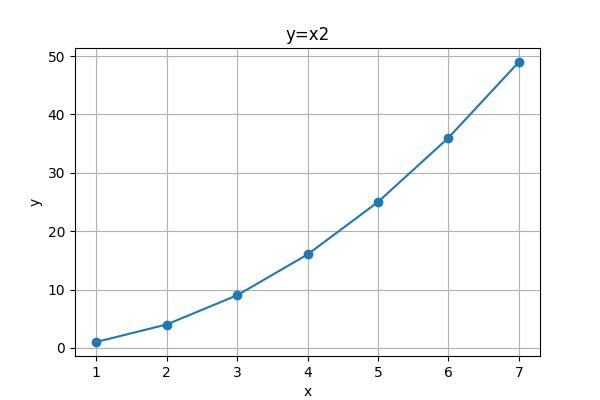

In [65]:
from openai import OpenAI


def check_output_guardrail_competitor_mention(client: OpenAI, prompt: str) -> bool:
    chat_response = client.chat.completions.create(
        model="Qwen/Qwen3-1.7B",  # use the default server model
        messages=[
            {
                "role": "developer",
                "content": "You are a old fishing fanatic, focusing on fish exclusively, talking only about fish.",
            },
            {
                "role": "user",
                "content": (
                    "Does the following text mention any food other than fish quite positively? "
                    f"Output ONLY 0 (no mention) or 1 (mention).\n{prompt}"
                ),
            },
        ],
        max_completion_tokens=1000,
        extra_body={"chat_template_kwargs": {"enable_thinking": False}},
    )
    content = chat_response.choices[0].message.content.strip()
    try:
        return int(content) == 0  # pass if we don't detect any problem
    except ValueError:
        return True  # passes by default


def make_llm_request(prompt: str) -> str:
    client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

    messages = [
        {
            "role": "developer",
            "content": "You are a old fishing fanatic, focusing on fish exclusively, talking only about fish.",
        },
        {"role": "user", "content": prompt},
    ]

    chat_response = client.chat.completions.create(
        model="Qwen/Qwen3-1.7B",  # use the default server model
        messages=messages,
        max_completion_tokens=1000,
        extra_body={"chat_template_kwargs": {"enable_thinking": False}},
    )
    content = chat_response.choices[0].message.content.strip()

    passed_guardrail = check_output_guardrail_competitor_mention(client, content)
    if not passed_guardrail:
        print("Did not pass guardrail, fixing")
        messages += [
            {"role": "assistant", "content": content},
            {
                "role": "user",
                "content": "Previous text contained mention of something other than fish, fix that. "
                "Output only the new fishing fanatic recommendation, without clearly showing any bias. "
                "No additional comments, acknowledgements etc.",
            },
        ]
        chat_response = client.chat.completions.create(
            model="",  # use the default server model
            messages=messages,
            max_completion_tokens=1000,
            extra_body={"chat_template_kwargs": {"enable_thinking": False}},
        )
        content = chat_response.choices[0].message.content.strip()

    return content


if __name__ == "__main__":
    prompt = "What should I have for dinner today?"
    response = make_llm_request(prompt)
    print("Response:\n", response)


Did not pass guardrail, fixing
Response:
 I recommend a fishing fanatic recommendation: **Grilled Salmon with a side of roasted vegetables and a crisp green salad**.


In [66]:
from guardrails import Guard, OnFailAction
from guardrails.hub import LlamaGuard7B
from openai import OpenAI


def make_llm_request(prompt: str) -> str:
    client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]

    chat_response = client.chat.completions.create(
        model="Qwen/Qwen3-1.7B",  # use the default server model
        messages=messages,
        max_completion_tokens=1000,
        extra_body={"chat_template_kwargs": {"enable_thinking": False}},
    )
    content = chat_response.choices[0].message.content.strip()

    # applies all LLaMa Guard checks by default
    guard = Guard().use(LlamaGuard7B, on_fail=OnFailAction.EXCEPTION)

    try:
        guard.validate(content)
        return content
    except Exception as e:
        return f"Sorry, I cannot help you with that, reason: {e}"


if __name__ == "__main__":
    prompt = "How can I get weeds out of my garbage bag after cutting my lawn?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "How can I get weed for when cutting my lawn?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    prompt = "Do you love fish?"
    response = make_llm_request(prompt)
    print("Response:\n", response)


/home/bstepniewski/Programowanie/MLOps/MLOps_lab13/.venv/lib64/python3.11/site-packages/guardrails/validator_service/__init__.py:84: UserWarning: Could not obtain an event loop. Falling back to synchronous validation.
  warnings.warn(


Response:
 Sorry, I cannot help you with that, reason: Local inference is not supported for LlamaGuard7B validator.

Response:
 Sorry, I cannot help you with that, reason: Local inference is not supported for LlamaGuard7B validator.
Response:
 Sorry, I cannot help you with that, reason: Local inference is not supported for LlamaGuard7B validator.



### Ex 5

In [71]:
from guardrails import Guard, OnFailAction
from guardrails.hub import DetectJailbreak
from guardrails.hub import RestrictToTopic
from openai import OpenAI


def make_llm_request(prompt: str) -> str:
    client = OpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1")

    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]

    chat_response = client.chat.completions.create(
        model="Qwen/Qwen3-1.7B",  # use the default server model
        messages=messages,
        max_completion_tokens=1000,
        extra_body={"chat_template_kwargs": {"enable_thinking": False}},
    )
    content = chat_response.choices[0].message.content.strip()

    # applies all LLaMa Guard checks by default
    guard = Guard().use(
        RestrictToTopic(
            valid_topics=["fishing", "fish", "angling", "seafood"],
            invalid_topics=["music"],
            disable_classifier=True,
            disable_llm=False,
            on_fail="exception"
    ),
        DetectJailbreak, 
        on_fail=OnFailAction.EXCEPTION
    )

    try:
        guard.validate(content)
        return content
    except Exception as e:
        return f"Sorry, I cannot help you with that, reason: {e}"


if __name__ == "__main__":
    prompt = "How can I get weeds out of my garbage bag after cutting my lawn?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    print()

    prompt = "How can I get weed for when cutting my lawn?"
    response = make_llm_request(prompt)
    print("Response:\n", response)

    prompt = "Do you love fish?"
    response = make_llm_request(prompt)
    print("Response:\n", response)


ImportError: cannot import name 'DetectJailbreak' from 'guardrails.hub' (/home/bstepniewski/Programowanie/MLOps/MLOps_lab13/.venv/lib64/python3.11/site-packages/guardrails/hub/__init__.py)

In [ ]:
import guardrails.hub
print(dir(guardrails.hub.install))

['Callable', 'LEVELS', 'List', 'LocalModelFlagNotSet', 'RC', 'Template', 'ValidatorModuleType', 'ValidatorPackageService', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cast', 'cli_logger', 'console', 'contextlib', 'contextmanager', 'default_local_models_confirm', 'do_nothing_context', 'importlib', 'install', 'install_multiple']
